Notebook purpose

- Decide how to identify savings transactions

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [2]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 1.82 seconds
Time for read_sample    : 4.68 minutes
(16,074,957, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088993,2012-04-02,57,23.74,1982 01apr 12 the broadway fruiterer london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-23,True,NaN,NaN,NaN,NaN,NaN,u,201204,NaN,22542.600586,2.425209
1,1088994,2012-04-02,57,25.68,1982 01apr 12 waitrose 835 crouch end gb,waitrose,spend,household,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-08-15,True,NaN,waitrose,"food, groceries, household",NaN,supermarket,u,201204,NaN,22542.600586,2.425209


## ISA transfers

Check whether identifiable transfers into ISA accounts are significant, in which case they would be a good additional outcome measure.

In [15]:
def isa_txns(df):
    return df[df.tag_auto.eq("isa")]


def savings_txns(df):
    return df[df.tag.eq("savings")]


isa = isa_txns(df)
savings = savings_txns(df)

The proportion of ISA payments is substantial

In [16]:
len(isa) / len(savings)

0.1733517081308479

As are the amounts

In [21]:
isa.amount.describe()

count     7170.000000
mean       270.075531
std       1177.184570
min          0.010000
25%         50.000000
50%        200.000000
75%        200.000000
max      20000.000000
Name: amount, dtype: float64

By far the most frequent amount is the monthly max allowance into the help to buy account

In [35]:
isa.amount.value_counts().iloc[:5]

200.0    3085
50.0      691
100.0     532
20.0      365
25.0      254
Name: amount, dtype: int64

## Tags

The simplest approach to identify savings is to use MDB auto tags. I have grouped all relevant auto tags into a `tag` called *savings*, which is a subgroup of the `tag_group` *transfters*.

In [20]:
tc.transfers_subgroups["savings"]

['general savings',
 'investment - other',
 'investments or shares',
 'isa',
 'pension or investments',
 'saving (general)',
 'savings (general)',
 'savings']

But there are not enough txns and users to work with, so I won't use these.

In [21]:
savings = df[df.tag.eq("savings")]
hd.txns_and_users(savings, df)

df1 has 43,745 txns across 2495 users (0.3% and 42.1% of df2).


## Savings account transfers

An alternative is to look at flows into and out of savings accounts. We could define something like 'monthly net savings' as the the sum of all inflows and outflows into a users savings accounts during a month.

In [7]:
savings = df[df.account_type.eq("savings")]
credits = savings[~savings.debit]
debits = savings[savings.debit]

There are many more transactions across many more users than for tags above.

In [8]:
hd.txns_and_users(savings, df)

df1 has 395,170 txns across 3425 users (2.7% and 57.8% of df2).


Plot distributions of monthly inflows, outflows, and net savings.

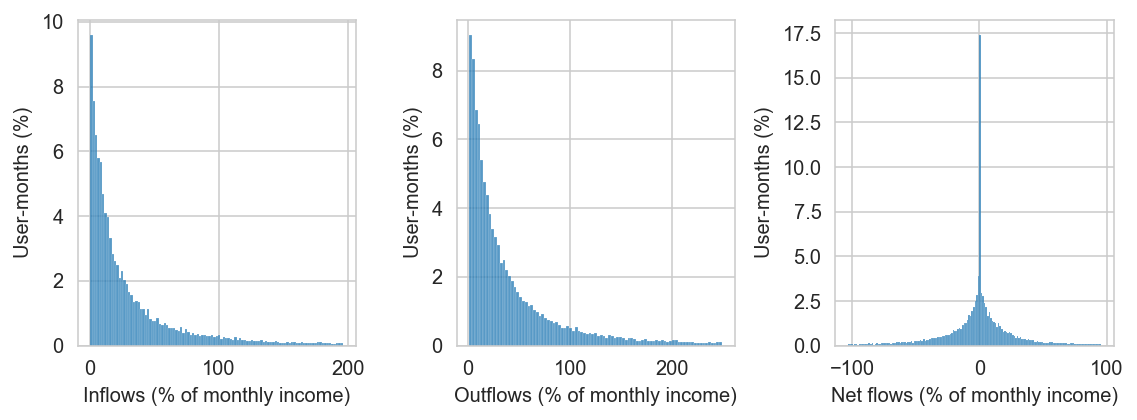

In [39]:
figs.sa_flows.main(df)

dev

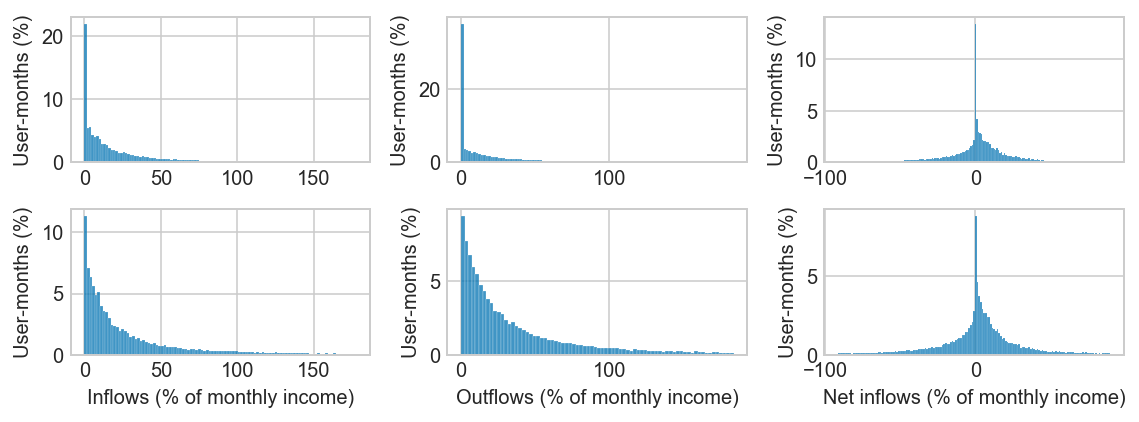

In [110]:
figs.sa_flows.main(df)

## Non-standing-order transactions

**Question**: Should we exclude standing order transactions from savings transactions identified above (as we'd expect entropy to affect non-standing order transactions only -- at least in the short-term)?

**Strategy**: Check whether standing orders account for a large proportion of inflows into savings accounts. If the proportion is significant, then we should exclude them and only focus on non-standing orders. If only very few transactions are standing orders, then there is no need to exclude them as they won't affect the results anyways.

**Tactic**: Ideally, we could check for the proportion of all standing orders from current to savings accounts. Identifying txns for which a current account debit standing order is mirrored by a savings account credit is a lot of work. We can bound that proportion, however: as a lower bound, we use the proportion of savings account credits that are standing orders (a few banks do tag these), and as an upper bound we use the proportion of all savings account credits that could be accounted for by current account debit standing orders.

**Limitations**:

- There will be standing orders that can't be identified from the txn description. So our universe of identified standing orders will be a subset of all true standing orders. Given our data, we could identify all txns where a current account debit matches a savings account credit and where this happens *regularly*. But we'd then have to define and operationalise regularly (i.e. definint it as 'monthly', and then define a window within which matching credits cound as monthly).

- As standing orders only make sense for debits, it's unclear what precisely savings account credit standing orders are. They could be transactions where a user has a current account debit standing order at the same bank, where the current account debit standing order is at another bank (though it's unlikely that a bank would then know that an incoming txns is the result of a standing order), or, even less likely, regularly credits into a savings account.

**Decision**: Assuming that the lower bounds are closer to the truth than the upper bounds (which is reasonable), standing orders seem to account for only a small fraction of savings account credits, especially in value, which is what we mostly care about. So we ignore them for now.

### Load data

Load raw data and perform partial cleaning (because txn description suffixes that, among other things, indicate standing orders get filtered out as part of the full data cleaning process).

In [3]:
fp = "s3://3di-data-mdb/raw/mdb_X77.parquet"
raw = (
    ha.read_parquet(fp)
    .pipe(cl.rename_cols)
    .pipe(cl.clean_headers)
    .pipe(cl.lowercase_categories)
    .pipe(cl.drop_missing_txn_desc)
)
hd.inspect(raw)

(6,959,731, 27)


,id,user_id,user_registration_date,user_yob,user_salary_range,user_postcode,user_lsoa,user_msoa,user_gender,date,account_id,account_provider,account_type,latest_balance,desc,credit_debit,amount,tag_up,tag_manual,tag_auto,merchant,merchant_business_line,account_created,account_last_refreshed,data_warehouse_date_created,data_warehouse_date_last_updated,updated_flag
0,688293,777,2011-07-20,1969.0,20k to 30k,wa1 4,e01012553,e02002603,m,2012-01-25,262916,natwest bank,current,364.220001,"9572 24jan12 , tcs bowdon , bowdon gb - pos",debit,25.030001,no tag,no tag,no tag,no merchant,unknown merchant,2011-07-20,2020-07-21 20:32:00,2014-07-18,2017-10-24,u
1,688291,777,2011-07-20,1969.0,20k to 30k,wa1 4,e01012553,e02002603,m,2012-01-25,262916,natwest bank,current,364.220001,warrington b.c. - d/d,debit,26.000000,gym membership,gym membership,no tag,no merchant,unknown merchant,2011-07-20,2020-07-21 20:32:00,2014-07-18,2017-10-23,u


In [4]:
data = raw

### Case study

List most commonly used banks:

In [130]:
data.account_provider.value_counts()[:5]

natwest bank                1080662
lloyds bank                  875908
halifax personal banking     836380
hsbc                         638038
santander                    558020
Name: account_provider, dtype: int64

Focus on single bank for now.

In [131]:
def get_bank_data(df, bank):
    return df[df.account_provider.eq(bank)]


bank_data = get_bank_data(data, "lloyds bank")

List most common txns descriptions for current account debit transfers to identify common identifiers for standing orders.

In [132]:
def get_current_account_debits(df):
    mask = df.account_type.eq("current") & df.credit_debit.eq("debit")
    return df[mask]


def get_transfers(df):
    return df[df.tag_auto.eq("transfers")]


bank_cad = get_current_account_debits(bank_data)
get_transfers(bank_cad).desc.value_counts()[:20]

<mdbremoved>                        12474
<mdbremoved>                         9061
save the change                      7052
save the change bp                   5811
<mdbremoved> tfr                     3347
<mdbremoved> so                      3051
<mdbremoved> xxxxxx xxxx8360 tfr      609
<mdbremoved> fpo                      403
<mdbremoved> xxxxxx xxxx1360          350
<mdbremoved> xxxxxx xxxx6660          284
<mdbremoved> xxxxxx xxxx0160          281
<mdbremoved> xxxxxx xxxx8360          271
<mdbremoved> xxxxxx xxxx4291 tfr      265
<mdbremoved> xxxxxx xxxx3560          248
savethechange-6668                    219
esavings account                      180
<mdbremoved> xxxxxx xxxx1560 tfr      177
club lloyds monthl so                 172
<mdbremoved> xxxxxx xxxx7568 tfr      152
savethechange-5060                    151
Name: desc, dtype: int64

Upper bounds: proportion of savings account credits that could be accounted for by current account debit standing orders.

In [133]:
def get_standing_orders(df):
    regex = r"standing order|\bso$|\bs/o$|\bsto$"
    return df[df.desc.str.contains(regex, regex=True)]


def get_savings_account_credits(df):
    mask = (
        df.account_type.eq("savings")
        & df.credit_debit.eq("credit")
        & ~df.tag_auto.str.contains("interest", na=False)
    )
    return df[mask]


def so_txns_pct(so_df, df):
    if so_df.empty:
        return np.nan
    return len(so_df) / len(df) * 100


def so_value_pct(so_df, df):
    if so_df.empty:
        return np.nan
    return so_df.amount.abs().sum() / df.amount.abs().sum() * 100


bank_cad_so = get_standing_orders(bank_cad)
bank_savings = get_savings_account_credits(bank_data)

print(so_txns_pct(bank_cad_so, bank_savings))
print(so_value_pct(bank_cad_so, bank_savings))

30.422715627668662
32.811641693115234


Lower bounds: proportion of savings account credits that are tagged as standing orders.

In [134]:
bank_savings_so = get_standing_orders(bank_savings)

print(so_txns_pct(bank_savings_so, bank_savings))
print(so_value_pct(bank_savings_so, bank_savings))

4.910333048676345
3.496024012565613


### All banks

Shows above metrics for most used banks in dataset.

In [135]:
headers = "Txns", "Value"
row = "{:30} | {:8.0f} | {:8.0f} | {:8.0f} | {:8.0f} |"
print("{:30} | {:^19} | {:^19} |".format("", "Lower bounds (%)", "Upper bounds (%)"))
print("{:30} | {:^8} | {:^8} | {:^8} | {:^8} |".format("Bank", *headers, *headers))
for bank in data.account_provider.value_counts().index[:10]:
    bank_data = get_bank_data(data, bank)
    bank_cad = get_current_account_debits(bank_data)
    bank_cad_so = get_standing_orders(bank_cad)
    bank_savings = get_savings_account_credits(bank_data)
    bank_savings_so = get_standing_orders(bank_savings)
    upper_txns = so_txns_pct(bank_cad_so, bank_savings)
    upper_value = so_value_pct(bank_cad_so, bank_savings)
    lower_txns = so_txns_pct(bank_savings_so, bank_savings)
    lower_value = so_value_pct(bank_savings_so, bank_savings)
    print(row.format(bank, lower_txns, lower_value, upper_txns, upper_value))

                               |  Lower bounds (%)   |  Upper bounds (%)   |
Bank                           |   Txns   |  Value   |   Txns   |  Value   |
natwest bank                   |      nan |      nan |      150 |       40 |
lloyds bank                    |        5 |        3 |       30 |       33 |
halifax personal banking       |       12 |        2 |       48 |       29 |
hsbc                           |      nan |      nan |       73 |       17 |
santander                      |      nan |      nan |      167 |       65 |
barclays                       |       24 |        2 |      179 |       60 |
nationwide                     |      nan |      nan |       78 |       41 |
american express               |      nan |      nan |      nan |      nan |
first direct                   |      nan |      nan |        1 |        1 |
royal bank of scotland (rbs)   |      nan |      nan |      306 |      109 |
